<a href="https://colab.research.google.com/github/semant/finance/blob/master/Time_Series_Uber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalizing Time Series Data by Seasonality to Predict Economic Activity
> Semant Jain, PhD
> semant@gmail.com


### Executive Summary
> Recent availability of satellite imagery has permitted analysis of retailer parking lots to predict economic activity. This activity may be used as a proxy for actual sales and have the capability to predict surprises in earning call annoucements. This effort would involve capturing data over a few years to normalize the seasonality effect, e.g., Black Friday, Christmas, or in-store sales. Other normalization factors include time of the day and the day of the week. While such images and granural retail data is stored in private databases, an Uber ride database from New York City was used to demonstrate data science methodology. This project consists of three parts:
> + First, the data is grouped into hourly and weekday chunks. Heatmap visualization reveals the highest and lowest demand period.
> + Second, t-test analysis on data grouped by weekday v. weekend reveals period of significantly higher hourly demand.
> + Finally, rides from two points of interest are visualized in a series of time lapsed heat maps.


### Contents

+ **1. Setting up**
     - Importing libraries
     - Importing data
     - Converting data to date/time
     - Grouping data into hourly chunks
+ **2. Data Visualization by Weekday Hour**    
     - Visualizing data: By day, hours
     - Grouping data
     - Mean rides per hour by weekday
     - Weekday rides by the hour
+ **3. Testing Seasonality**     
    - Hourly trends
    - Statistical significance
+ **4. Data Analysis at Points of Interest**
    - Computing distance
    - Computing distance using haversine formula
    - Summary statistics
    - Number of rides within a radius
    - Cumulative rides within a radius
    - Heatmap visualizations: By radius, hourly, timelapsed snap shots
    
### Python libraries
The following libraries were used in the analysis:
+ Calendar
+ Folium
+ Geopy
+ Math
+ Matplotlib
+ Pandas
+ Scipy
+ Seaborn

---

# 1. Setting up

### Importing libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import calendar
import seaborn as sns

! python3 -m pip install geopy
import geopy.distance

!pip install folium
import folium as folium

### Importing data

In [0]:
uber_data = pd.read_csv("../data/uber-raw-data-jul14.csv")
print(uber_data.head(5))

          Date/Time      Lat      Lon    Base
0  7/1/2014 0:03:00  40.7586 -73.9706  B02512
1  7/1/2014 0:05:00  40.7605 -73.9994  B02512
2  7/1/2014 0:06:00  40.7320 -73.9999  B02512
3  7/1/2014 0:09:00  40.7635 -73.9793  B02512
4  7/1/2014 0:20:00  40.7204 -74.0047  B02512


### Converting data to date/time

In [0]:
#Convert the type of the column to datetime
uber_data["Date/Time"] = pd.to_datetime(uber_data["Date/Time"])

### Grouping data into hourly chunks

In [0]:
#Using a floor can round off the date-time into discrete increments
print(uber_data["Date/Time"].dt.floor('1H').head(5))

0   2014-07-01
1   2014-07-01
2   2014-07-01
3   2014-07-01
4   2014-07-01
Name: Date/Time, dtype: datetime64[ns]


In [0]:
#Let's get value counts to see the number of trips at given times
print(uber_data["Date/Time"].dt.floor('1H').value_counts().head(5))

2014-07-15 18:00:00    3302
2014-07-15 19:00:00    3225
2014-07-15 17:00:00    3045
2014-07-02 18:00:00    2946
2014-07-15 20:00:00    2840
Name: Date/Time, dtype: int64


In [0]:
#And sort the data so it is chronological
hourly_data = uber_data["Date/Time"].dt.floor('1H').value_counts()
hourly_data = hourly_data.sort_index()
print(hourly_data.head(5), "\n")
print(hourly_data.tail(5))

2014-07-01 00:00:00    216
2014-07-01 01:00:00    111
2014-07-01 02:00:00     82
2014-07-01 03:00:00    134
2014-07-01 04:00:00    223
Name: Date/Time, dtype: int64 

2014-07-31 19:00:00    2430
2014-07-31 20:00:00    2460
2014-07-31 21:00:00    2275
2014-07-31 22:00:00    2099
2014-07-31 23:00:00    1382
Name: Date/Time, dtype: int64


--- 
# 2. Data Analysis by Day/Hour

### Visualizing data: Grouped by day and hours

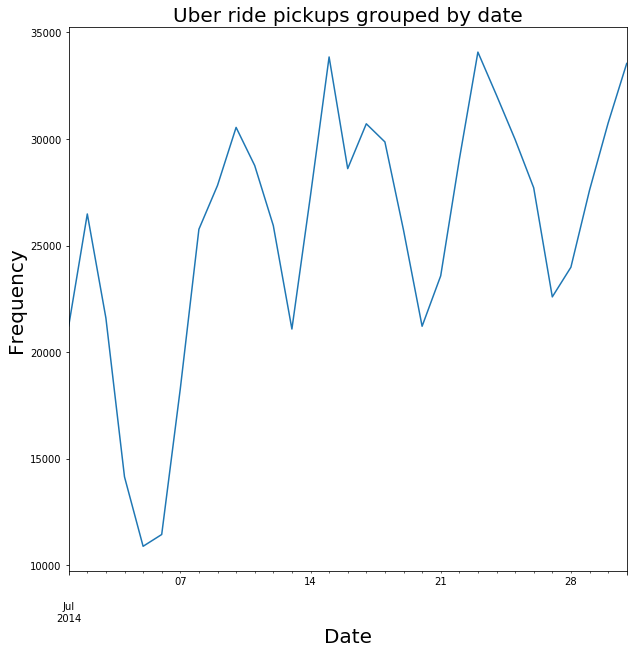

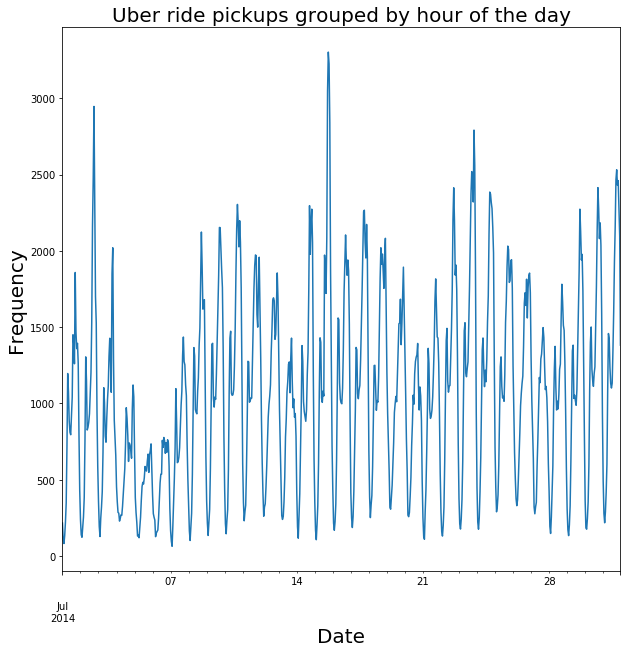

In [0]:
# Data grouped by day
day_data = uber_data["Date/Time"].dt.floor('D').value_counts()
day_data = day_data.sort_index()
day_data.plot(kind="line", figsize = (10,10))
plt.title('Uber ride pickups grouped by date', size= 20)
plt.xlabel('Date', size= 20)
plt.ylabel('Frequency', size= 20)
plt.show()

# Data grouped by hour
hourly_data.plot(kind="line", figsize = (10,10))
plt.title('Uber ride pickups grouped by hour of the day', size= 20)
plt.xlabel('Date', size= 20)
plt.ylabel('Frequency', size= 20)

plt.show()

### Grouping data
+ Hourly
+ Week day
+ Date

In [0]:
hours = uber_data["Date/Time"].dt.hour
week_day = uber_data["Date/Time"].dt.weekday
date = uber_data["Date/Time"].dt.date
weekly_data = pd.concat([week_day, hours, date], axis=1)
weekly_data.columns = ["Week Day", "Hour", "Date"]

print(weekly_data.head(5))

   Week Day  Hour        Date
0         1     0  2014-07-01
1         1     0  2014-07-01
2         1     0  2014-07-01
3         1     0  2014-07-01
4         1     0  2014-07-01


### Mapping Week Day from a number to characters

In [0]:
print(calendar.day_name[0], "\n")

weekly_data["Week Day"] = weekly_data["Week Day"].apply(lambda x: calendar.day_name[x])
print(weekly_data["Week Day"].head(5))

Monday 

0    Tuesday
1    Tuesday
2    Tuesday
3    Tuesday
4    Tuesday
Name: Week Day, dtype: object


### Grouping the data by date, weekday, and hour

In [0]:
weekly_data = weekly_data.groupby(["Date","Week Day", "Hour"]).size()
print(weekly_data.head(5))

Date        Week Day  Hour
2014-07-01  Tuesday   0       216
                      1       111
                      2        82
                      3       134
                      4       223
dtype: int64


In [0]:
weekly_data = weekly_data.reset_index()
print(weekly_data.head(5))

         Date Week Day  Hour    0
0  2014-07-01  Tuesday     0  216
1  2014-07-01  Tuesday     1  111
2  2014-07-01  Tuesday     2   82
3  2014-07-01  Tuesday     3  134
4  2014-07-01  Tuesday     4  223


In [0]:
weekly_data = weekly_data.rename(columns={0: "Size"})
print(weekly_data.head(5))

         Date Week Day  Hour  Size
0  2014-07-01  Tuesday     0   216
1  2014-07-01  Tuesday     1   111
2  2014-07-01  Tuesday     2    82
3  2014-07-01  Tuesday     3   134
4  2014-07-01  Tuesday     4   223


### Mean rides for each week day / hour

In [0]:
weekly_data = weekly_data.groupby(["Week Day", "Hour"]).mean()["Size"]
print(weekly_data.head(5))

Week Day  Hour
Friday    0       615.00
          1       385.25
          2       264.75
          3       307.50
          4       339.75
Name: Size, dtype: float64


### Weekday rides by the hour

In [0]:
weekly_data = weekly_data.unstack(level=0)
#print(weekly_data)

In [0]:
weekly_data = weekly_data.reindex(columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
print(weekly_data)

Week Day   Monday  Tuesday  Wednesday  Thursday   Friday  Saturday   Sunday
Hour                                                                       
0          315.00    301.8      354.6     430.0   615.00   1110.25  1090.00
1          153.25    155.8      193.2     231.4   385.25    788.25   829.50
2          109.75    111.2      156.0     171.0   264.75    580.00   638.25
3          254.75    187.0      224.0     256.6   307.50    426.00   477.00
4          403.75    296.6      326.0     376.8   339.75    271.75   245.50
5          615.25    546.0      559.8     586.2   497.25    274.25   231.25
6          911.00    962.2     1003.4     959.2   736.75    303.50   256.75
7         1266.50   1350.0     1425.8    1341.8  1008.00    398.50   316.25
8         1199.25   1332.4     1425.0    1336.6  1038.00    525.25   466.75
9          923.00   1012.2     1083.8    1077.0   907.75    667.00   657.50
10         855.75    977.4     1035.2    1014.2   875.75    823.25   801.25
11         8

### Visualization: Hourly rides by weekday

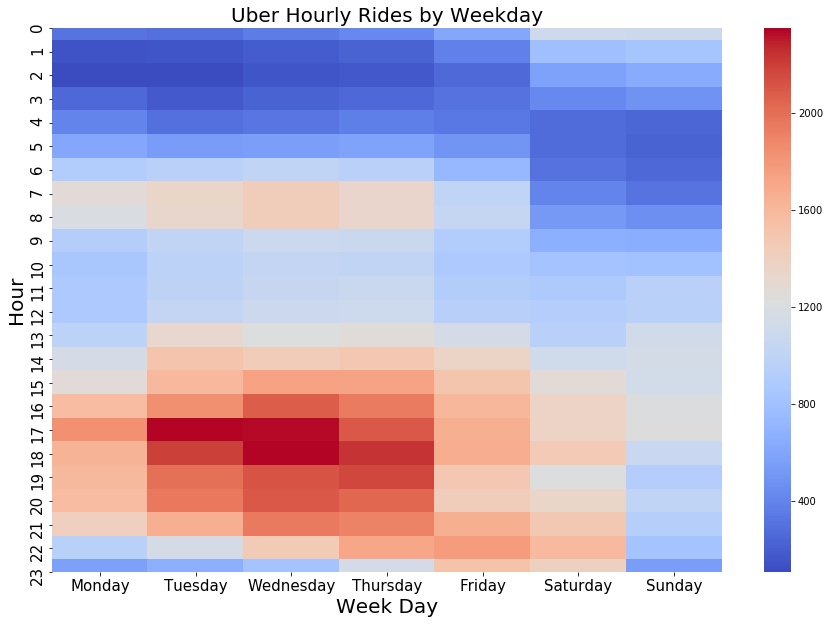

In [0]:
plt.subplots(figsize=(15,10))
plt.xlabel("Weekday", fontsize = 20)
plt.ylabel("Hour of the day", fontsize = 20)
plt.title("Uber Hourly Rides by Weekday", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=90)
sns.heatmap(weekly_data, cmap='coolwarm')
plt.savefig('EDHEC_02_UberRidesWeekdayHour.jpeg')
plt.show()

---

# 3. Testing Seasonality
+ Hourly trends
+ Weekday trends
+ Data normalization

In [0]:
### Hourly trends

In [0]:
h = hourly_data.groupby(hourly_data.index.hour).mean()
# h.plot(kind="line")
# plt.show()

### Hourly trends: Weekday vs. Weekend

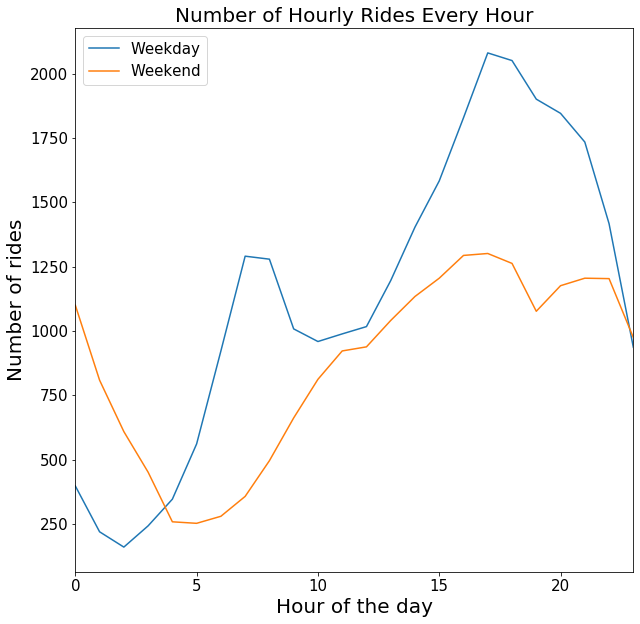

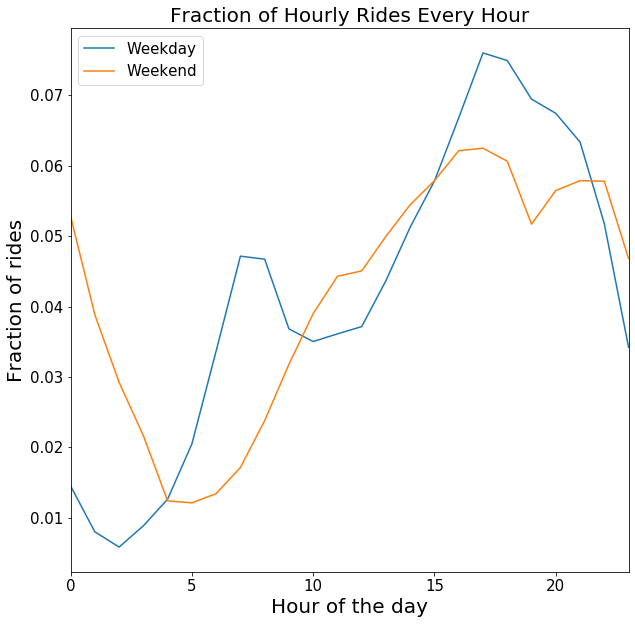

In [0]:
i = hourly_data.index.weekday <= 4

h_week = hourly_data.loc[i].groupby(hourly_data.loc[i].index.hour).mean()
h_weekend = hourly_data.loc[~i].groupby(hourly_data.loc[~i].index.hour).mean()
h = pd.concat([h_week, h_weekend], axis=1)
h.columns = ["Weekday", "Weekend"]
# print(h)

h.plot(kind='line', figsize = (10,10))
plt.ylabel("Number of rides", fontsize = 20)
plt.xlabel("Hour of the day", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 15)
plt.title("Number of Hourly Rides Every Hour", fontsize = 20)
plt.show()

(h / h.sum()).plot(kind='line', figsize = (10,10))
plt.ylabel("Fraction of rides", fontsize = 20)
plt.xlabel("Hour of the day", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 15)
plt.title("Fraction of Hourly Rides Every Hour", fontsize = 20)
plt.show()

### Statistical significance: Difference in ridership by the hour

In [0]:
from scipy.stats import ttest_ind

#The functions takes two samples and returns the t-stat and the p-value denoting the null hypothesis that they are the same
#print(ttest_ind([100,105,110], [200,230,210]))

In [0]:
#Now for each day, let's normalize by the total number of rides in the day
hourly_data_pct = hourly_data.groupby(hourly_data.index.date).apply(lambda x: x / x.sum())
#print(hourly_data_pct)

In [0]:
#For each group of hours, we will apply a function to test the null hypothesis where the first sample is
#weekdays and the second is weekends found by taking the days of the index
t_stats = hourly_data_pct.groupby(hourly_data_pct.index.hour).apply(lambda x: ttest_ind(x[x.index.weekday<=4], x[x.index.weekday>4])[0])
#print(t_stats)

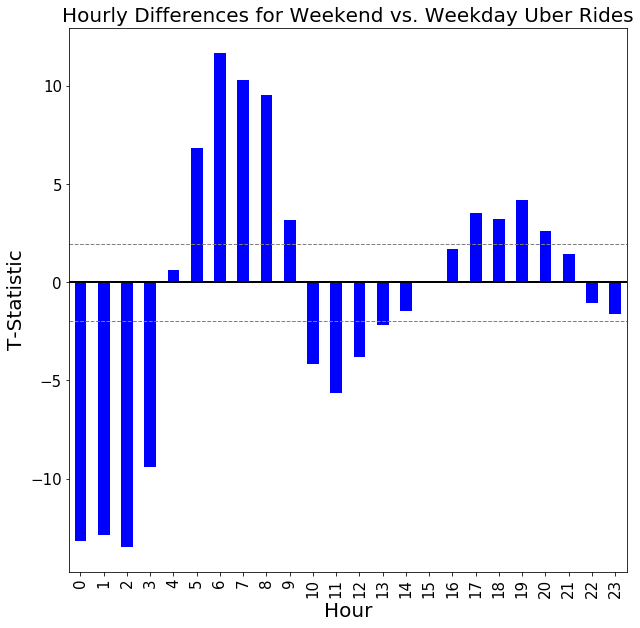

In [0]:
ax = t_stats.plot(kind = 'bar', color='blue', figsize = (10,10))
ax.axhline(1.96, linestyle='--', color='grey', linewidth=1)
ax.axhline(0, color='black', linewidth=2)
ax.axhline(-1.96, linestyle='--', color='grey', linewidth=1)
plt.xlabel("Hour", fontsize = 20)
plt.ylabel("T-Statistic", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Hourly Differences for Weekend vs. Weekday Uber Rides", fontsize = 20)
plt.savefig('EDHEC_02_02_UberRidesT_Statistic.jpeg')
plt.show()

---

# 4. Data Analysis at Points of Interest

### Comparison of Rides between Two Points
+ ESB: Empire State Building
+ MM : Metropolitan Museum of Art

### Computing distance between the two points of interest

In [0]:
# Specification of Latitude, Longitudes
metro_art_coordinates = (40.7794, -73.9632)
empire_state_building_coordinates = (40.7484, -73.9857)
distance = geopy.distance.distance(metro_art_coordinates, empire_state_building_coordinates)
print(f"These two points are {distance} miles and {distance.mi} miles far apart")

These two points are 3.9319431838516716 km miles and 2.443196223959372 miles far apart


In [0]:
print(uber_data[["Lat", "Lon"]].apply(lambda x: tuple(x),axis=1))

0         (40.7586, -73.9706)
1         (40.7605, -73.9994)
2          (40.732, -73.9999)
3         (40.7635, -73.9793)
4         (40.7204, -74.0047)
                 ...         
796116    (40.7285, -73.9846)
796117    (40.7615, -73.9868)
796118     (40.677, -73.9515)
796119    (40.7225, -74.0038)
796120    (40.7199, -73.9884)
Length: 796121, dtype: object


### Computing distance using haversine formula

In [0]:
from math import radians, cos, sin, asin, sqrt

def haversine(coordinates1, coordinates2):

    lon1 = coordinates1[1]
    lat1 = coordinates1[0]
    lon2 = coordinates2[1]
    lat2 = coordinates2[0]
    #Change to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    
    # Apply the harversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956
    return c * r

print("Distance between the two points using haversine formula is ", haversine(metro_art_coordinates, empire_state_building_coordinates), "miles")

Distance between the two points using haversine formula is  2.442501323483997 miles


In [0]:
uber_data["Distance MM"] = uber_data[["Lat", "Lon"]].apply(lambda x: haversine(metro_art_coordinates,tuple(x)),axis=1)
uber_data["Distance ESB"] = uber_data[["Lat", "Lon"]].apply(lambda x: haversine(empire_state_building_coordinates,tuple(x)),axis=1)
print(uber_data["Distance MM"].head(5), "\n")
print(uber_data["Distance ESB"].head(5))

0    1.487358
1    2.299140
2    3.794105
3    1.383450
4    4.615925
Name: Distance MM, dtype: float64 

0    1.058178
1    1.100642
2    1.354266
3    1.094999
4    2.173858
Name: Distance ESB, dtype: float64


### Summary statistics on rides from the two points of interest 

In [0]:
print(uber_data[["Distance MM", "Distance ESB"]].describe())

         Distance MM   Distance ESB
count  796121.000000  796121.000000
mean        3.868244       2.723783
std         3.200848       3.276343
min         0.037592       0.000000
25%         1.863763       0.976621
50%         3.329218       1.726115
75%         4.691434       3.037256
max        86.770131      88.188585


### Number of rides within a certain radius

In [0]:
### Within a 0.25 mile radius

print((uber_data[["Distance MM", "Distance ESB"]] < .25).sum())

Distance MM      2764
Distance ESB    15133
dtype: int64


In [0]:
### Number of rides within a 5 mile radius in 0.1 mile increments

import numpy as np
#Distance range takes a start, end (non-inclusive) and step amount
distance_range = np.arange(.1,5.1,.1)
# print(distance_range)

In [0]:
#Run analysis for each distance

distance_data = [(uber_data[["Distance MM", "Distance ESB"]] < dist).sum() for dist in distance_range]
# print(distance_data)

In [0]:
# Printing a sample of entries
print ("No of entries: ", len(distance_data), "\n")
for i in range(5):
    print(i, distance_data[i]["Distance MM"], distance_data[i]["Distance ESB"])

No of entries:  50 

0 575 2387
1 1776 9661
2 4566 22166
3 8783 42427
4 13606 68011


In [0]:
#Concatenating the data
distance_data = pd.concat(distance_data, axis=1)
#print(distance_data)

In [0]:
# Adding the index
distance_data = distance_data.transpose()
distance_data.index = distance_range
#print(distance_data)

### Visualization: Cumulative rides within a certain radius

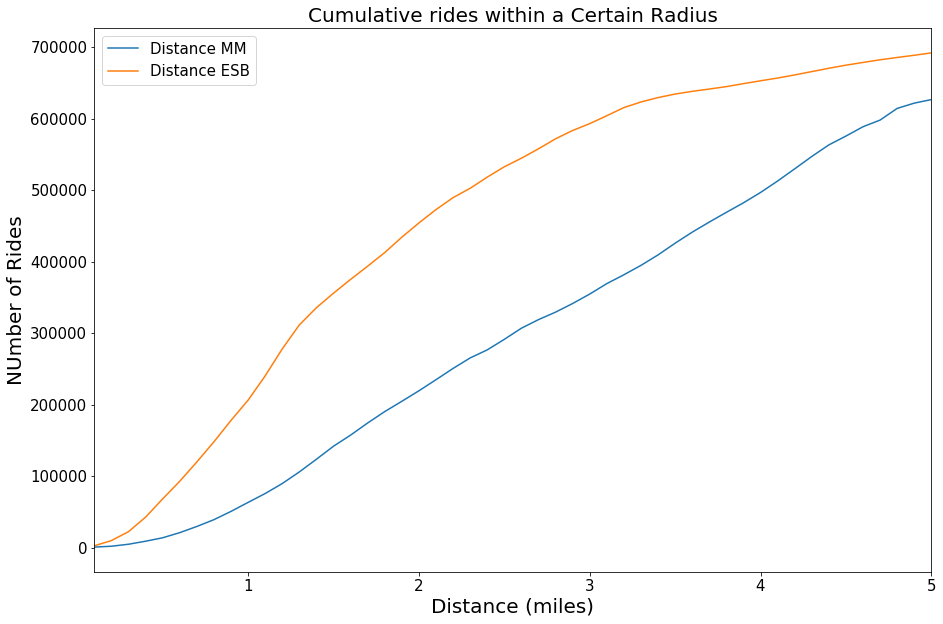

In [0]:
distance_data.plot(kind="line", figsize = (15,10))
plt.xlabel("Distance (miles)", fontsize = 20)
plt.ylabel("NUmber of Rides", fontsize = 20)
plt.title("Cumulative rides within a Certain Radius", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 15)
plt.show()

### Visualization: Mapping Data with Folium

In [0]:
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
#uber_map

In [0]:
# Visualizing first 5 riders

lat = uber_data["Lat"].values[:5]
lon = uber_data["Lon"].values[:5]


uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for i in range(len(lat)):
    folium.Marker((lat[i], lon[i]), popup="Rider {}".format(i+1)).add_to(uber_map)
uber_map

### Heat Map Visualization for the first 10,000 rides
+ Within a 13 mile radius

In [0]:
from folium.plugins import HeatMap

lat_lon = uber_data[["Lat", "Lon"]].values[:10000]
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
HeatMap(lat_lon, radius=13).add_to(uber_map)
uber_map

### Heat Map Visualization for the first 10,000 rides
+ Within a 30 mile radius - To the airport

In [0]:
lat_lon = uber_data[["Lat", "Lon"]].values[:10000]
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
HeatMap(lat_lon, radius=30).add_to(uber_map)
uber_map

### Heat Map Visualization for the first 10,000 rides
+ Reducing weight of each data point to increase clarity
+ Within a 15 mile radius

In [0]:
uber_data["Weight"] = .5
lat_lon = uber_data[["Lat", "Lon", "Weight"]].values[:10000]
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

HeatMap(lat_lon, radius=15).add_to(uber_map)
uber_map

### Restricting analysis to a certain radius around each point of interest

In [0]:
i = uber_data[["Distance MM", "Distance ESB"]] < .25
# print(i)

In [0]:
#Take data where either one is true
i = i.any(axis=1)
# print(i)

In [0]:
#This is our map data
map_data = uber_data[i].copy()
# print(map_data)

### Visualization

In [0]:
map_data["Weight"] = .01
lat_lon = map_data[["Lat", "Lon", "Weight"]].values
#uber_map = folium.Map(location=[40.7728, -74.0060], zoom_start=14)
uber_map = folium.Map(location=[40.7600, -74.0060], zoom_start=14)
HeatMap(lat_lon, radius=20).add_to(uber_map)
uber_map

### Analyzing data by the hour

In [0]:
uber_data["Date_Hour"] = uber_data["Date/Time"].apply(lambda x: x.replace(microsecond=0,second=0,minute=0))
# print(uber_data["Date_Hour"])

### Restricting analysis to the first week
+ Randomly sampling 1/3 of the data
+ Visualization as time lapsed snap shots

In [0]:
from datetime import datetime
map_data = uber_data[uber_data["Date/Time"] < datetime(2014,7,8)].copy()
map_data["Weight"] = .5


map_data = map_data.groupby('Date_Hour').apply(lambda x: x[["Lat", "Lon", "Weight"]].sample(int(len(x)/3)).values.tolist())
date_hour_index = [x.strftime("%m/%d/%Y, %H:%M:%S") for x in map_data.index]
date_hour_data = map_data.tolist()

### Timelapsed Movie: Visualization by the hour 

In [0]:
from folium.plugins import HeatMapWithTime
uber_map = folium.Map(location=[40.7128, -74.0060], zoom_start=14)

hm = HeatMapWithTime(date_hour_data, index=date_hour_index)
hm.add_to(uber_map)
uber_map